<a href="https://www.kaggle.com/code/beyzasuner/braintumordetection?scriptVersionId=264041991" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-detection/no/34 no.jpg
/kaggle/input/brain-tumor-mri-detection/no/N20.JPG
/kaggle/input/brain-tumor-mri-detection/no/N1.JPG
/kaggle/input/brain-tumor-mri-detection/no/49 no.jpg
/kaggle/input/brain-tumor-mri-detection/no/N15.jpg
/kaggle/input/brain-tumor-mri-detection/no/No18.jpg
/kaggle/input/brain-tumor-mri-detection/no/31 no.jpg
/kaggle/input/brain-tumor-mri-detection/no/no 6.jpg
/kaggle/input/brain-tumor-mri-detection/no/3 no.jpg
/kaggle/input/brain-tumor-mri-detection/no/no 5.jpeg
/kaggle/input/brain-tumor-mri-detection/no/no 1.jpg
/kaggle/input/brain-tumor-mri-detection/no/26 no.jpg
/kaggle/input/brain-tumor-mri-detection/no/N26.JPG
/kaggle/input/brain-tumor-mri-detection/no/N5.jpg
/kaggle/input/brain-tumor-mri-detection/no/6 no.jpg
/kaggle/input/brain-tumor-mri-detection/no/No21.jpg
/kaggle/input/brain-tumor-mri-detection/no/17 no.jpg
/kaggle/input/brain-tumor-mri-detection/no/No22.jpg
/kaggle/input/brain-tumor-mri-detection/no/29 no.jpg
/kaggle/inpu

# 🧠 Brain Tumor MRI Detection – Custom CNN (RGB)
Bu notebook’ta Brain Tumor MRI Detection veri seti ile Convolutional Neural Network (CNN) tabanlı bir model geliştirilmiştir.
Amaç: MRI görüntülerinden tümör var/yok sınıflandırması yapabilen bir derin öğrenme modeli oluşturmak.

In [2]:
# ===============================
# Setup
# ===============================
import os, random, time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Reproducibility
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cpu


## 📊 Veri Önişleme
- Dataset: `brain_tumor_dataset` klasöründeki `no` ve `yes` alt klasörleri.  
- Görseller 128x128 boyutuna dönüştürüldü.  
- Normalizasyon [-1, 1] aralığına getirildi.  
- Data Augmentation: Horizontal Flip + Rotation.  
- Eğitim/Doğrulama ayrımı: %80 / %20.  
- Batch size = 32.


In [3]:
# ===============================
# Dataset (RGB - 3 channels, doğru yol)
# ===============================
DATA_DIR = Path("/kaggle/input/brain-tumor-mri-detection/brain_tumor_dataset")

IMG_SIZE = 128
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

valid_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

# Artık sadece ['no', 'yes'] olacak
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_tfms)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Train/Validation split
val_ratio = 0.2
n_total = len(full_dataset)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val
train_ds, val_ds = random_split(full_dataset, [n_train, n_val])

val_ds.dataset.transform = valid_tfms

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

Classes: ['no', 'yes']


## 🏗️ Model Mimarisi
Modelimiz Custom CNN olup 3 adet convolutional layer, maxpool, dropout ve fully connected katmanlardan oluşmaktadır.




In [4]:
# ===============================
# CNN Model (RGB input)
# ===============================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, dropout=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # RGB input
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.drop  = nn.Dropout(dropout)
        self.fc1   = nn.Linear(128 * (IMG_SIZE//8) * (IMG_SIZE//8), 256)
        self.fc2   = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.drop(F.relu(self.fc1(x)))
        return self.fc2(x)

model = SimpleCNN(num_classes).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 📈 Eğitim Süreci
Model 15 epoch boyunca eğitilecek. Her epoch’ta train/val loss ve accuracy ölçülecek.


In [5]:
# ===============================
# Training Loop
# ===============================
EPOCHS = 15
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}

def run_epoch(loader, train=True):
    model.train(train)
    total, correct, running_loss = 0,0,0.0
    for X,y in loader:
        X,y = X.to(DEVICE), y.to(DEVICE)
        if train: optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            out = model(X)
            loss = criterion(out,y)
            if train:
                loss.backward(); optimizer.step()
        running_loss += loss.item()*X.size(0)
        pred = out.argmax(1)
        correct += (pred==y).sum().item()
        total += X.size(0)
    return running_loss/total, correct/total

for epoch in range(1,EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    val_loss, val_acc = run_epoch(val_loader, False)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(val_acc)
    print(f"Epoch {epoch}: train_acc={tr_acc:.3f} val_acc={val_acc:.3f}")

Epoch 1: train_acc=0.547 val_acc=0.680
Epoch 2: train_acc=0.606 val_acc=0.680
Epoch 3: train_acc=0.680 val_acc=0.720
Epoch 4: train_acc=0.764 val_acc=0.660
Epoch 5: train_acc=0.635 val_acc=0.680
Epoch 6: train_acc=0.764 val_acc=0.780
Epoch 7: train_acc=0.808 val_acc=0.680
Epoch 8: train_acc=0.813 val_acc=0.780
Epoch 9: train_acc=0.808 val_acc=0.720
Epoch 10: train_acc=0.803 val_acc=0.740
Epoch 11: train_acc=0.833 val_acc=0.720
Epoch 12: train_acc=0.823 val_acc=0.780
Epoch 13: train_acc=0.867 val_acc=0.760
Epoch 14: train_acc=0.882 val_acc=0.760
Epoch 15: train_acc=0.916 val_acc=0.780


## 📊 Değerlendirme
- Accuracy/Loss grafikleri, Confusion Matrix ve Classification Report ile modelin başarımı ölçülmüştür. Modelin doğrulama başarımı %78 civarında. Train/val farkı çok büyük olmadığı için aşırı overfitting gözlenmemektedir.


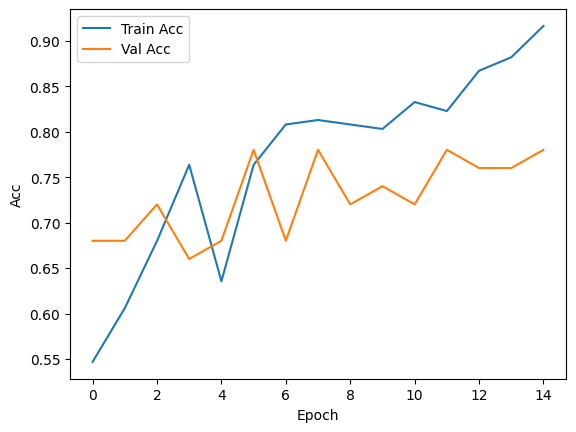

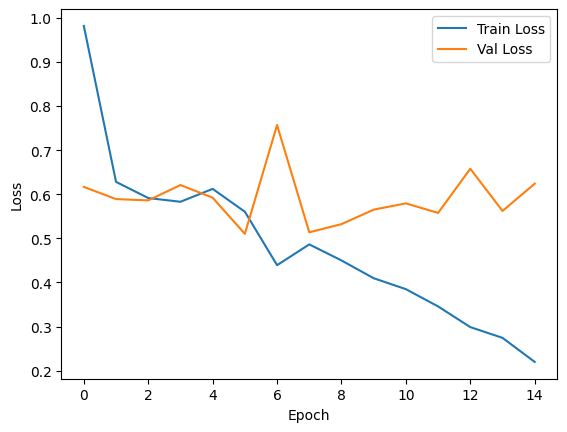

              precision    recall  f1-score   support

          no       0.63      0.75      0.69        16
         yes       0.87      0.79      0.83        34

    accuracy                           0.78        50
   macro avg       0.75      0.77      0.76        50
weighted avg       0.79      0.78      0.78        50



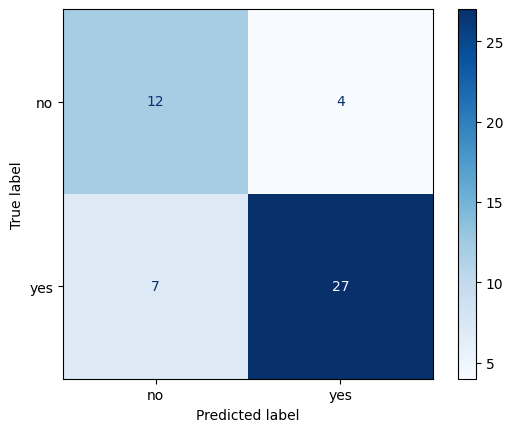

In [6]:
# ===============================
# Accuracy & Loss Plots
# ===============================
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend(); plt.show()

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# ===============================
# Confusion Matrix & Report
# ===============================
y_true,y_pred = [],[]
model.eval()
with torch.no_grad():
    for X,y in val_loader:
        X,y = X.to(DEVICE), y.to(DEVICE)
        out = model(X)
        pred = out.argmax(1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

print(classification_report(y_true,y_pred,target_names=class_names))
cm = confusion_matrix(y_true,y_pred)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap="Blues")
plt.show()

## 🔥 Grad-CAM Görselleştirme
Modelin hangi bölgelerden etkilendiğini göstermek için Grad-CAM uygulanır.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


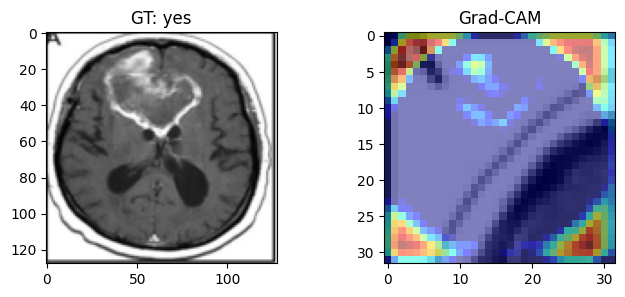

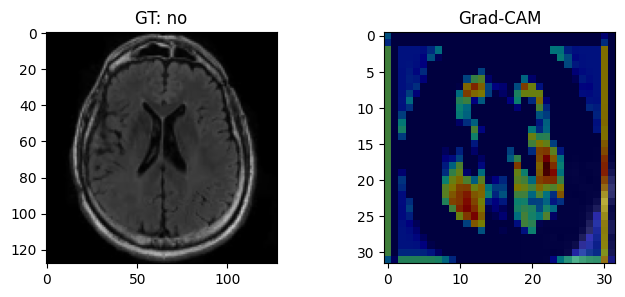

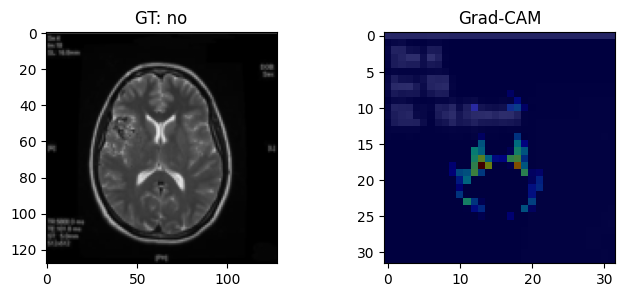

In [7]:
# ===============================
# Grad-CAM
# ===============================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
    def save_activation(self, module, input, output):
        self.activations = output.detach()
    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()
    def __call__(self, x, class_idx=None):
        out = self.model(x)
        if class_idx is None:
            class_idx = out.argmax(1)
        loss = out[:,class_idx]
        self.model.zero_grad()
        loss.backward(torch.ones_like(loss))
        weights = self.gradients.mean(dim=(2,3), keepdim=True)
        cam = (weights*self.activations).sum(dim=1,keepdim=True)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max()+1e-8)
        return cam

gradcam = GradCAM(model, model.conv3)

imgs, labels = next(iter(val_loader))
imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
cams = gradcam(imgs)

for i in range(3):
    img = imgs[i].cpu().permute(1,2,0).numpy()
    img = (img*0.5+0.5) # denormalize
    cam = cams[i,0].cpu().numpy()
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1); plt.imshow(img); plt.title(f"GT: {class_names[labels[i]]}")
    plt.subplot(1,2,2); plt.imshow(img); plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM"); plt.show()

## ⚙️ Hiperparametre Optimizasyonu
Farklı learning rate, batch size ve dropout değerleri denenmiştir.


In [8]:
# ===============================
# Hyperparameter Experiments
# ===============================
def train_with_params(lr=1e-3, batch_size=32, dropout=0.5, epochs=5):
    model = SimpleCNN(num_classes, dropout=dropout).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    history = {"train_acc":[],"val_acc":[]}
    for epoch in range(epochs):
        tr_loss,tr_acc = run_epoch(train_loader, True)
        val_loss,val_acc = run_epoch(val_loader, False)
        history["train_acc"].append(tr_acc)
        history["val_acc"].append(val_acc)
        print(f"[lr={lr}, bs={batch_size}, drop={dropout}] Epoch {epoch+1}: Val Acc={val_acc:.3f}")
    return history

# Örnek denemeler
h1 = train_with_params(lr=1e-3, batch_size=32, dropout=0.5)
h2 = train_with_params(lr=5e-4, batch_size=32, dropout=0.5)
h3 = train_with_params(lr=1e-3, batch_size=64, dropout=0.3)

[lr=0.001, bs=32, drop=0.5] Epoch 1: Val Acc=0.840
[lr=0.001, bs=32, drop=0.5] Epoch 2: Val Acc=0.780
[lr=0.001, bs=32, drop=0.5] Epoch 3: Val Acc=0.820
[lr=0.001, bs=32, drop=0.5] Epoch 4: Val Acc=0.680
[lr=0.001, bs=32, drop=0.5] Epoch 5: Val Acc=0.800
[lr=0.0005, bs=32, drop=0.5] Epoch 1: Val Acc=0.780
[lr=0.0005, bs=32, drop=0.5] Epoch 2: Val Acc=0.800
[lr=0.0005, bs=32, drop=0.5] Epoch 3: Val Acc=0.780
[lr=0.0005, bs=32, drop=0.5] Epoch 4: Val Acc=0.780
[lr=0.0005, bs=32, drop=0.5] Epoch 5: Val Acc=0.740
[lr=0.001, bs=64, drop=0.3] Epoch 1: Val Acc=0.740
[lr=0.001, bs=64, drop=0.3] Epoch 2: Val Acc=0.780
[lr=0.001, bs=64, drop=0.3] Epoch 3: Val Acc=0.760
[lr=0.001, bs=64, drop=0.3] Epoch 4: Val Acc=0.760
[lr=0.001, bs=64, drop=0.3] Epoch 5: Val Acc=0.760
